# Emotion Classification Based On Comments (Emotion Dataset)
This Code Created By: [Krisna Santosa](https://www.dicoding.com/users/krisna_santosa)

dataset from: [Emotion Dataset Kaggle](https://www.kaggle.com/datasets/abdallahwagih/emotion-dataset/code)

## Preparation

In [1]:
# Unzip the dataset
!unzip Emotion_classify_Data.zip

Archive:  Emotion_classify_Data.zip
  inflating: Emotion_classify_Data.csv  


In [2]:
# Import Libraries
import pandas as pd
import tensorflow as tf
import nltk
import string

from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import ModelCheckpoint
from nltk.corpus import stopwords

## Data Explorary / Data Preprocessing

In [3]:
# Download stopwords from NLTK
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [4]:
# Read Datasets as Dataframe
df = pd.read_csv("Emotion_classify_Data.csv")
df.head(7)

,Comment,Emotion
0,i seriously hate one subject to death but now ...,fear
1,im so full of life i feel appalled,anger
2,i sit here to write i start to dig out my feel...,fear
3,ive been really angry with r and i feel like a...,joy
4,i feel suspicious if there is no one outside l...,fear
5,i feel jealous becasue i wanted that kind of l...,anger
6,when a friend of mine keeps telling me morbid ...,anger


In [5]:
# Remove stopwords and punctuation
def preprocess_text(text):
    # Convert text to lowercase
    text = text.lower()
    # Remove punctuation
    text = ''.join([char for char in text if char not in string.punctuation])
    # Remove stopwords
    text = ' '.join([word for word in text.split() if word not in stop_words])
    return text

# Apply preprocessing to the 'Comment' column
df['Comment'] = df['Comment'].apply(preprocess_text)
df['Comment']

0       seriously hate one subject death feel reluctan...
1                              im full life feel appalled
2       sit write start dig feelings think afraid acce...
3       ive really angry r feel like idiot trusting fi...
4       feel suspicious one outside like rapture happe...
                              ...                        
5932                                begun feel distressed
5933    left feeling annoyed angry thinking center stu...
5934    ever get married everything ready offer got to...
5935    feel reluctant applying want able find company...
5936           wanted apologize feel like heartless bitch
Name: Comment, Length: 5937, dtype: object

In [6]:
# One-Hot Encoding
category = pd.get_dummies(df.Emotion)
new_df = pd.concat([df, category], axis=1)
new_df = new_df.drop(columns='Emotion')
new_df

,Comment,anger,fear,joy
0,seriously hate one subject death feel reluctan...,0,1,0
1,im full life feel appalled,1,0,0
2,sit write start dig feelings think afraid acce...,0,1,0
3,ive really angry r feel like idiot trusting fi...,0,0,1
4,feel suspicious one outside like rapture happe...,0,1,0
...,...,...,...,...
5932,begun feel distressed,0,1,0
5933,left feeling annoyed angry thinking center stu...,1,0,0
5934,ever get married everything ready offer got to...,0,0,1
5935,feel reluctant applying want able find company...,0,1,0


In [7]:
# Splitting Dataset to Train and Test
X = new_df['Comment'].values
y = new_df.iloc[:, 1:]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

## Tokenization, Sequences, and Padding

In [8]:
tokenizer = Tokenizer(num_words=5000, oov_token='<oov>')

tokenizer.fit_on_texts(X_train)
tokenizer.fit_on_texts(X_test)

train_sequence = tokenizer.texts_to_sequences(X_train)
test_sequence = tokenizer.texts_to_sequences(X_test)

train_padded = pad_sequences(train_sequence, maxlen=300)
test_padded = pad_sequences(test_sequence, maxlen=300)

## Training Model

In [9]:
# Make Model Architecture
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=5000, output_dim=300),
    tf.keras.layers.LSTM(128),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(3, activation='softmax')
])

# Define a callback to save the best model based on validation accuracy
checkpoint = ModelCheckpoint("best_model.h5", monitor="val_accuracy", save_best_only=True, mode="max", verbose=1)

model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 300)         1500000   
                                                                 
 lstm (LSTM)                 (None, 128)               219648    
                                                                 
 dense (Dense)               (None, 128)               16512     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 3)                 1

In [10]:
# Train Model
num_epochs = 30
history = model.fit(
    train_padded,
    y_train,
    epochs=num_epochs,
    validation_data=(test_padded, y_test),
    verbose=2,
    callbacks=[checkpoint]  # Add the checkpoint callback
)

Epoch 1/30

Epoch 1: val_accuracy improved from -inf to 0.86700, saving model to best_model.h5
149/149 - 29s - loss: 0.9454 - accuracy: 0.5016 - val_loss: 0.4026 - val_accuracy: 0.8670 - 29s/epoch - 194ms/step
Epoch 2/30


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 2: val_accuracy improved from 0.86700 to 0.94360, saving model to best_model.h5
149/149 - 6s - loss: 0.2108 - accuracy: 0.9396 - val_loss: 0.1893 - val_accuracy: 0.9436 - 6s/epoch - 37ms/step
Epoch 3/30

Epoch 3: val_accuracy improved from 0.94360 to 0.94613, saving model to best_model.h5
149/149 - 5s - loss: 0.0604 - accuracy: 0.9844 - val_loss: 0.2461 - val_accuracy: 0.9461 - 5s/epoch - 32ms/step
Epoch 4/30

Epoch 4: val_accuracy improved from 0.94613 to 0.95286, saving model to best_model.h5
149/149 - 3s - loss: 0.0329 - accuracy: 0.9922 - val_loss: 0.2235 - val_accuracy: 0.9529 - 3s/epoch - 23ms/step
Epoch 5/30

Epoch 5: val_accuracy did not improve from 0.95286
149/149 - 3s - loss: 0.0237 - accuracy: 0.9939 - val_loss: 0.2519 - val_accuracy: 0.9402 - 3s/epoch - 19ms/step
Epoch 6/30

Epoch 6: val_accuracy did not improve from 0.95286
149/149 - 3s - loss: 0.0143 - accuracy: 0.9960 - val_loss: 0.2618 - val_accuracy: 0.9478 - 3s/epoch - 17ms/step
Epoch 7/30

Epoch 7: val_accura

## Monitor The Model

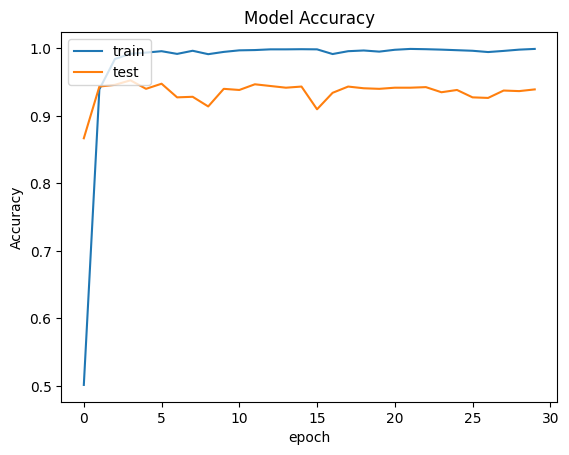

In [11]:
# Monitor Accuracy of The Model
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

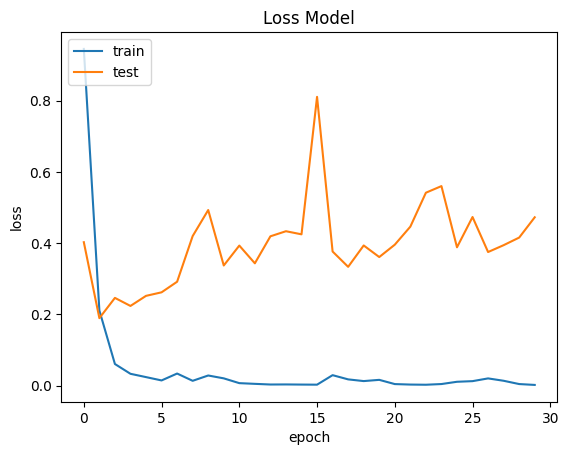

In [13]:
# Monitor Loss of The Model
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss Model')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()